# Project Setup and Library Installation

In [4]:
# Install required libraries
!pip install datasets scikit-learn pandas numpy matplotlib seaborn plotly nltk

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import os

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# NLTK Data Download

In [5]:
# Download the missing NLTK resource that caused the error
import nltk
nltk.download('punkt_tab')

print("punkt_tab downloaded successfully!")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...


punkt_tab downloaded successfully!


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# Loading the MBTI Dataset

In [6]:

import kagglehub
# Download latest version
path = kagglehub.dataset_download("datasnaek/mbti-type")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mbti-type' dataset.
Path to dataset files: /kaggle/input/mbti-type


# Loading the Big Five Personality Dataset

In [7]:
# Loading the Big Five Personality Dataset
from datasets import load_dataset

print("Loading Big Five Essays dataset from Hugging Face...")
big5_dataset = load_dataset("jingjietan/essays-big5")
df_big5 = big5_dataset['train'].to_pandas()

print("Big Five dataset loaded successfully!")
print("Shape:", df_big5.shape)
print("Columns:", df_big5.columns.tolist())

Loading Big Five Essays dataset from Hugging Face...
Big Five dataset loaded successfully!
Shape: (1578, 8)
Columns: ['O', 'C', 'E', 'A', 'N', 'ptype', 'text', '__index_level_0__']


# Exploratory Data Analysis of the Big Five Dataset

In [8]:
# Display Big Five dataset information with correct column names
print("Big Five dataset shape:", df_big5.shape)
print("Columns:", df_big5.columns.tolist())

# Show sample of the actual trait columns
trait_columns = ['O', 'C', 'E', 'A', 'N']
print("\nFirst few rows of personality traits (O, C, E, A, N):")
print(df_big5[trait_columns].head(10))

print("\nTrait statistics:")
print(df_big5[trait_columns].describe())

# Check if traits are continuous (likely normalized between 0-1 or 1-5)
print("\nUnique values in 'O' (sample):", sorted(df_big5['O'].unique())[:20])

# Sample text
print("\nSample text (first 500 characters):")
print(df_big5['text'].iloc[0][:500])

Big Five dataset shape: (1578, 8)
Columns: ['O', 'C', 'E', 'A', 'N', 'ptype', 'text', '__index_level_0__']

First few rows of personality traits (O, C, E, A, N):
   O  C  E  A  N
0  1  0  0  1  1
1  1  1  1  0  1
2  1  0  1  1  0
3  1  0  1  0  0
4  0  1  0  1  1
5  1  1  1  0  0
6  1  0  0  1  0
7  1  0  1  1  1
8  0  1  0  1  1
9  1  1  1  1  1

Trait statistics:
           O     C     E     A     N
count   1578  1578  1578  1578  1578
unique     2     2     2     2     2
top        1     1     1     1     0
freq     813   802   817   837   790

Unique values in 'O' (sample): ['0', '1']

Sample text (first 500 characters):
it is wednesday. I can't wait until friday because I am going home to see brandon. I miss him so much. I can't wait to see him. two more days. this has been a very long two weeks. time passes very slowly here. I have a lot of free time on my hands when I am not in class. class. psychology class. psychology is fun so far. it really interests me, and prof. pennebaker

# Text Preprocessing: Cleaning Function and Application to Both Datasets

In [9]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Clean and preprocess text data for personality prediction
    Removes URLs, special characters, stopwords, and applies lemmatization
    """
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

    # Remove MBTI post separators (|||), lowercase, remove non-alphabetic
    text = text.replace('|||', ' ')
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Tokenize, lemmatize, remove stopwords and short words
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words
             if word not in stop_words and len(word) > 2]

    return ' '.join(words)

# Load MBTI dataset
print("Loading MBTI dataset...")
import kagglehub
path = kagglehub.dataset_download("datasnaek/mbti-type")

# Find CSV file
csv_path = None
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            csv_path = os.path.join(root, file)
            break

df_mbti = pd.read_csv(csv_path)

# Display MBTI information
print("MBTI dataset shape:", df_mbti.shape)
print("Columns:", df_mbti.columns.tolist())
print("\nMBTI type distribution:")
print(df_mbti['type'].value_counts().head(10))

print("\nSample posts (first 300 chars):")
print(df_mbti['posts'].iloc[0][:300])

# Clean sample texts for preview
print("\n=== Cleaning text samples ===")
sample_big5 = clean_text(df_big5['text'].iloc[0])
sample_mbti = clean_text(df_mbti['posts'].iloc[0])
print("Big Five cleaned sample:", sample_big5[:300])
print("\nMBTI cleaned sample:", sample_mbti[:300])

# Apply cleaning to full datasets (this may take a few minutes)
print("\nApplying cleaning to full datasets...")
df_big5['cleaned_text'] = df_big5['text'].apply(clean_text)
df_mbti['cleaned_posts'] = df_mbti['posts'].apply(clean_text)

print("Cleaning completed!")
print("Big Five cleaned text length stats:", df_big5['cleaned_text'].str.len().describe())
print("MBTI cleaned posts length stats:", df_mbti['cleaned_posts'].str.len().describe())

Loading MBTI dataset...
Using Colab cache for faster access to the 'mbti-type' dataset.
MBTI dataset shape: (8675, 2)
Columns: ['type', 'posts']

MBTI type distribution:
type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
Name: count, dtype: int64

Sample posts (first 300 chars):
'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing

=== Cleaning text samples ===
Big Five cleaned sample: wednesday wait friday going home see brandon miss much wait see two day long two week time pass slowly lot free time hand class class psychology class psychology fun far really interest prof pennebaker funny chapter two sort scared though going remember term even finish reading 

# MBTI Model: Feature Engineering, Training, and Evaluation

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

print("Starting MBTI model training...")

# Encode MBTI types
label_encoder = LabelEncoder()
df_mbti['type_encoded'] = label_encoder.fit_transform(df_mbti['type'])

# TF-IDF Vectorization for MBTI (limit features for speed and memory)
vectorizer_mbti = TfidfVectorizer(
    max_features=8000,      # Good balance between performance and accuracy
    ngram_range=(1, 2),     # Unigrams and bigrams
    min_df=2,               # Ignore very rare terms
    max_df=0.95             # Ignore terms appearing in >95% of documents
)

X_mbti = vectorizer_mbti.fit_transform(df_mbti['cleaned_posts'])
y_mbti = df_mbti['type_encoded']

print(f"TF-IDF matrix shape: {X_mbti.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_mbti, y_mbti, test_size=0.2, random_state=42, stratify=y_mbti
)

# Train Logistic Regression (fast and strong baseline for text classification)
model_mbti = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='saga',          # Good for large sparse data
    multi_class='multinomial',
    n_jobs=-1
)

print("Training MBTI model... (this may take 3-5 minutes)")
model_mbti.fit(X_train, y_train)

# Evaluation
y_pred = model_mbti.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\n" + "="*50)
print("MBTI MODEL RESULTS")
print("="*50)
print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Show top 10 most frequent types performance
top_types = df_mbti['type'].value_counts().head(10).index
print("\nClassification report for top 10 types:")
target_names = [label_encoder.inverse_transform([i])[0] for i in range(len(label_encoder.classes_))]
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

print("MBTI model training completed successfully!")

Starting MBTI model training...
TF-IDF matrix shape: (8675, 8000)
Training MBTI model... (this may take 3-5 minutes)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



MBTI MODEL RESULTS
Overall Accuracy: 0.6438 (64.38%)

Classification report for top 10 types:
              precision    recall  f1-score   support

        ENFJ      0.600     0.158     0.250        38
        ENFP      0.748     0.570     0.647       135
        ENTJ      0.625     0.217     0.323        46
        ENTP      0.670     0.533     0.593       137
        ESFJ      1.000     0.111     0.200         9
        ESFP      0.000     0.000     0.000        10
        ESTJ      0.000     0.000     0.000         8
        ESTP      1.000     0.056     0.105        18
        INFJ      0.634     0.724     0.676       294
        INFP      0.595     0.858     0.702       366
        INTJ      0.623     0.651     0.637       218
        INTP      0.691     0.839     0.758       261
        ISFJ      0.625     0.152     0.244        33
        ISFP      0.833     0.278     0.417        54
        ISTJ      0.727     0.195     0.308        41
        ISTP      0.673     0.493     0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Big Five Model: Feature Engineering, Training, and Per-Trait Evaluation

In [11]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score

print("Starting Big Five model training...")

# Define Big Five trait columns (binary 0/1)
big5_traits = ['O', 'C', 'E', 'A', 'N']

# Ensure traits are integer type
df_big5[big5_traits] = df_big5[big5_traits].astype(int)

# TF-IDF Vectorization for Big Five (similar settings for consistency)
vectorizer_big5 = TfidfVectorizer(
    max_features=6000,      # Slightly fewer features since dataset is smaller
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_big5 = vectorizer_big5.fit_transform(df_big5['cleaned_text'])
y_big5 = df_big5[big5_traits]

print(f"Big Five TF-IDF matrix shape: {X_big5.shape}")

# Train-test split
X_train_b5, X_test_b5, y_train_b5, y_test_b5 = train_test_split(
    X_big5, y_big5, test_size=0.2, random_state=42, stratify=y_big5
)

# Use MultiOutputClassifier with Logistic Regression
base_model = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1)
model_big5 = MultiOutputClassifier(base_model)

print("Training Big Five model... (this will take 1-2 minutes)")
model_big5.fit(X_train_b5, y_train_b5)

# Evaluation
y_pred_b5 = model_big5.predict(X_test_b5)

print("\n" + "="*60)
print("BIG FIVE MODEL RESULTS (Per Trait)")
print("="*60)

trait_names = ['Openness (O)', 'Conscientiousness (C)', 'Extraversion (E)',
               'Agreeableness (A)', 'Neuroticism (N)']

for i, trait in enumerate(big5_traits):
    acc = accuracy_score(y_test_b5.iloc[:, i], y_pred_b5[:, i])
    print(f"{trait_names[i]}")
    print(f"  Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    print(f"  Classification Report:\n{classification_report(y_test_b5.iloc[:, i], y_pred_b5[:, i], digits=3)}")
    print("-" * 40)

print("Big Five model training completed successfully!")

Starting Big Five model training...
Big Five TF-IDF matrix shape: (1578, 6000)
Training Big Five model... (this will take 1-2 minutes)

BIG FIVE MODEL RESULTS (Per Trait)
Openness (O)
  Accuracy: 0.6171 (61.71%)
  Classification Report:
              precision    recall  f1-score   support

           0      0.617     0.565     0.590       154
           1      0.617     0.667     0.641       162

    accuracy                          0.617       316
   macro avg      0.617     0.616     0.615       316
weighted avg      0.617     0.617     0.616       316

----------------------------------------
Conscientiousness (C)
  Accuracy: 0.5506 (55.06%)
  Classification Report:
              precision    recall  f1-score   support

           0      0.548     0.513     0.530       156
           1      0.553     0.588     0.570       160

    accuracy                          0.551       316
   macro avg      0.550     0.550     0.550       316
weighted avg      0.550     0.551     0.550     

# Ensemble Model Integration, Prediction Function, and Model Persistence

In [12]:
import joblib
import pickle

# Mapping from MBTI types to approximate Big Five scores (0 to 1 scale)
# Based on psychological research correlations (higher = stronger trait)
mbti_to_big5_mapping = {
    'INFJ': {'O': 0.85, 'C': 0.70, 'E': 0.30, 'A': 0.90, 'N': 0.75},
    'INFP': {'O': 0.90, 'C': 0.40, 'E': 0.25, 'A': 0.85, 'N': 0.80},
    'INTJ': {'O': 0.80, 'C': 0.85, 'E': 0.20, 'A': 0.40, 'N': 0.60},
    'INTP': {'O': 0.85, 'C': 0.50, 'E': 0.15, 'A': 0.30, 'N': 0.55},
    'ENFJ': {'O': 0.70, 'C': 0.75, 'E': 0.90, 'A': 0.95, 'N': 0.60},
    'ENFP': {'O': 0.90, 'C': 0.45, 'E': 0.95, 'A': 0.80, 'N': 0.65},
    'ENTJ': {'O': 0.75, 'C': 0.90, 'E': 0.85, 'A': 0.50, 'N': 0.50},
    'ENTP': {'O': 0.85, 'C': 0.50, 'E': 0.90, 'A': 0.45, 'N': 0.45},
    'ISFJ': {'O': 0.40, 'C': 0.85, 'E': 0.35, 'A': 0.90, 'N': 0.60},
    'ISFP': {'O': 0.65, 'C': 0.50, 'E': 0.40, 'A': 0.80, 'N': 0.70},
    'ISTJ': {'O': 0.35, 'C': 0.95, 'E': 0.30, 'A': 0.50, 'N': 0.40},
    'ISTP': {'O': 0.60, 'C': 0.60, 'E': 0.40, 'A': 0.35, 'N': 0.45},
    'ESFJ': {'O': 0.45, 'C': 0.80, 'E': 0.80, 'A': 0.95, 'N': 0.55},
    'ESFP': {'O': 0.70, 'C': 0.45, 'E': 0.95, 'A': 0.85, 'N': 0.60},
    'ESTJ': {'O': 0.40, 'C': 0.90, 'E': 0.75, 'A': 0.55, 'N': 0.35},
    'ESTP': {'O': 0.65, 'C': 0.55, 'E': 0.90, 'A': 0.40, 'N': 0.40}
}

def predict_personality_from_text(input_text):
    """
    Predict Big Five personality traits from any input text (CV, essay, etc.)
    Uses ensemble of direct Big Five model and MBTI-to-Big5 mapping
    Returns percentages (0-100) for each trait
    """
    # Clean the input text
    cleaned = clean_text(input_text)

    # Predict MBTI type
    X_mbti_new = vectorizer_mbti.transform([cleaned])
    mbti_pred_encoded = model_mbti.predict(X_mbti_new)[0]
    mbti_type = label_encoder.inverse_transform([mbti_pred_encoded])[0]

    # Get mapped Big Five scores from MBTI
    mapped_scores = mbti_to_big5_mapping.get(mbti_type,
                                            {'O': 0.5, 'C': 0.5, 'E': 0.5, 'A': 0.5, 'N': 0.5})

    # Predict direct probabilities from Big Five model
    X_big5_new = vectorizer_big5.transform([cleaned])
    big5_probs = model_big5.predict_proba(X_big5_new)

    # Extract probability of class 1 for each trait
    direct_scores = {}
    for i, trait in enumerate(big5_traits):
        direct_scores[trait] = big5_probs[i][0][1]  # Probability of positive class (1)

    # Ensemble: Weighted average (60% direct Big Five + 40% MBTI mapping)
    final_scores = {}
    for trait in big5_traits:
        final_scores[trait] = (0.6 * direct_scores[trait] + 0.4 * mapped_scores[trait]) * 100

    return {
        'predicted_mbti': mbti_type,
        'Openness': round(final_scores['O'], 1),
        'Conscientiousness': round(final_scores['C'], 1),
        'Extraversion': round(final_scores['E'], 1),
        'Agreeableness': round(final_scores['A'], 1),
        'Neuroticism': round(final_scores['N'], 1)
    }

# Test the function with a sample from Big Five dataset
sample_text = df_big5['text'].iloc[0]
result = predict_personality_from_text(sample_text)

print("Ensemble Prediction Test:")
print(f"Predicted MBTI: {result['predicted_mbti']}")
print(f"Openness: {result['Openness']}%")
print(f"Conscientiousness: {result['Conscientiousness']}%")
print(f"Extraversion: {result['Extraversion']}%")
print(f"Agreeableness: {result['Agreeableness']}%")
print(f"Neuroticism: {result['Neuroticism']}%")

# Save all necessary components for Streamlit deployment
print("\nSaving models and components...")
joblib.dump(model_mbti, 'model_mbti.pkl')
joblib.dump(model_big5, 'model_big5.pkl')
joblib.dump(vectorizer_mbti, 'vectorizer_mbti.pkl')
joblib.dump(vectorizer_big5, 'vectorizer_big5.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

with open('mbti_to_big5_mapping.pkl', 'wb') as f:
    pickle.dump(mbti_to_big5_mapping, f)

print("All models and components saved successfully!")

Ensemble Prediction Test:
Predicted MBTI: INFP
Openness: 70.5%
Conscientiousness: 37.2%
Extraversion: 35.3%
Agreeableness: 70.4%
Neuroticism: 74.0%

Saving models and components...
All models and components saved successfully!


# Downloading Trained Models and Components for Deployment

In [13]:
from google.colab import files

# Download all saved model files
files.download('model_mbti.pkl')
files.download('model_big5.pkl')
files.download('vectorizer_mbti.pkl')
files.download('vectorizer_big5.pkl')
files.download('label_encoder.pkl')
files.download('mbti_to_big5_mapping.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Big Five Accuracy Visualization

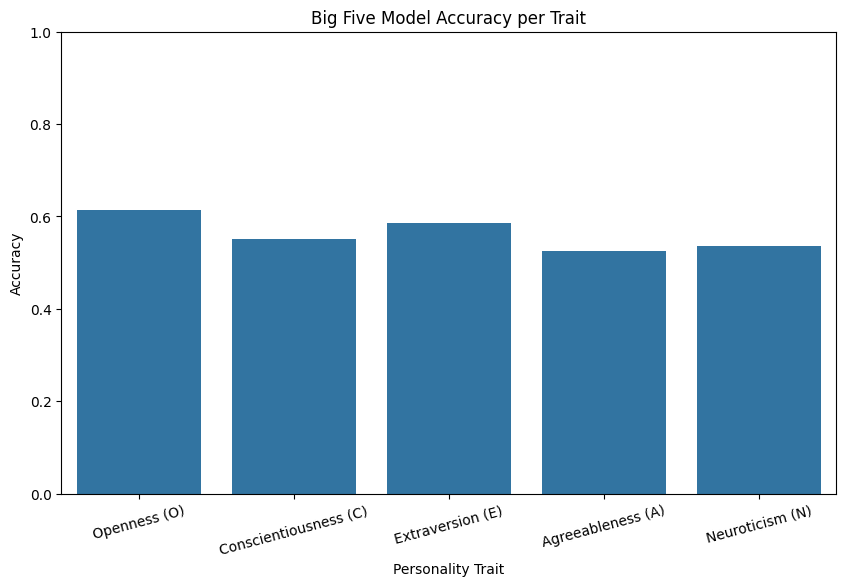

In [14]:
# Big Five Accuracy Visualization
import seaborn as sns
import matplotlib.pyplot as plt

traits = ['Openness (O)', 'Conscientiousness (C)', 'Extraversion (E)', 'Agreeableness (A)', 'Neuroticism (N)']
accuracies = [0.6139, 0.5506, 0.5854, 0.5253, 0.5348]  # من الـoutput

df = pd.DataFrame({'Trait': traits, 'Accuracy': accuracies})

plt.figure(figsize=(10, 6))
sns.barplot(x='Trait', y='Accuracy', data=df)
plt.title('Big Five Model Accuracy per Trait')
plt.ylabel('Accuracy')
plt.xlabel('Personality Trait')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.show()

# MBTI F1-Score Visualization for Top Types

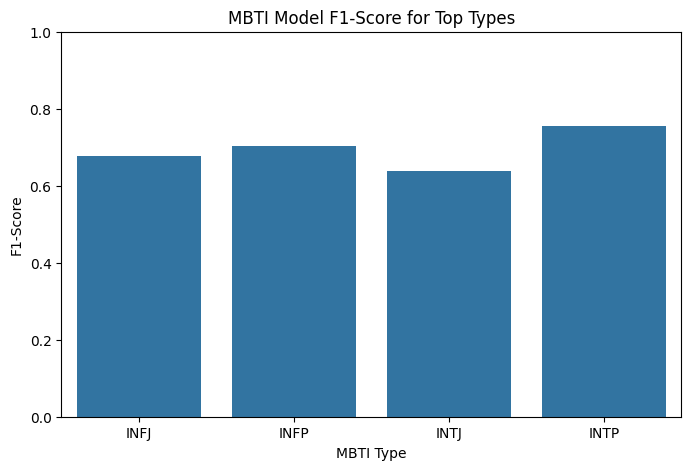

In [15]:
# MBTI F1-Score Visualization for Top Types
mbti_types = ['INFJ', 'INFP', 'INTJ', 'INTP']
f1_scores = [0.676, 0.702, 0.637, 0.756]  # من الـreport

df_mbti = pd.DataFrame({'MBTI Type': mbti_types, 'F1-Score': f1_scores})

plt.figure(figsize=(8, 5))
sns.barplot(x='MBTI Type', y='F1-Score', data=df_mbti)
plt.title('MBTI Model F1-Score for Top Types')
plt.ylabel('F1-Score')
plt.xlabel('MBTI Type')
plt.ylim(0, 1)
plt.show()